In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Create data

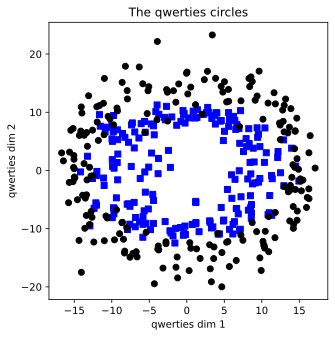

In [36]:
nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [r1*np.cos(th) + np.random.randn(nPerClust) * 3 , 
     r1*np.sin(th) + np.random.randn(nPerClust)]
b = [r2*np.cos(th) + np.random.randn(nPerClust),
     r2*np.sin(th) + np.random.randn(nPerClust) * 3]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concate to matrix
data_np = np.hstack((a,b)).T 

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels == 0)[0],0],data[np.where(labels == 0)[0],1],'bs')
plt.plot(data[np.where(labels == 1)[0],0],data[np.where(labels == 1)[0],1],'ko')
plt.title("The qwerties circles")
plt.xlabel("qwerties dim 1")
plt.ylabel("qwerties dim 2")
plt.show()

### Separate the data into dataLoader

In [37]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=.2)

# convert into pytorch datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

# translate into data loader
batchSize = 16 
train_loader = DataLoader(train_data,batch_size=batchSize,shuffle=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [38]:
class Net(nn.Module):
     def __init__(self,dropoutRate):
        super().__init__()
        
        ### layers
        self.input = nn.Linear(2,128)
        self.hidden = nn.Linear(128,128)
        self.output = nn.Linear(128,1)
        
        # parameters
        self.dr = dropoutRate
         
     def forward(self, x):
         
         x = F.relu(self.input(x))
         
         # dropout after input layer , self.training means is set true when model is in train mode
         x = F.dropout(x, p=self.dr,training=self.training)
         
         x = F.relu( self.hidden(x) )
         
         x = F.dropout(x, p=self.dr,training=self.training)
         
         x = self.output(x)
         
         return x

In [39]:
# testing code and model
tmpNet = Net(.25)

tmpdata = torch.randn((10,2))
yhat = tmpNet(tmpdata)
yhat

tensor([[-0.2602],
        [-0.0994],
        [-0.0827],
        [ 0.1256],
        [-0.0161],
        [-0.1168],
        [ 0.0498],
        [-0.0354],
        [-0.2176],
        [ 0.0455]], grad_fn=<AddmmBackward0>)

In [40]:
# function to create model
def createNet(dropoutRate):
    
    ANNQC = Net(dropoutRate)
    
    lossFn = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr=0.002)
    
    return ANNQC, lossFn, optimizer

In [41]:
# train the model
num_epochs = 1000

def trainNet(ANNQC, lossFn,optimizer):
    
    trainAcc = []
    testAcc = []
    
    
    
    for epochI in range(num_epochs):
        # switch training mode on
        ANNQC.train()
            
        batchAcc = []
        for X,y in train_loader:
            
            yHat = ANNQC(X)
            loss = lossFn(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            batchAcc.append(100*torch.mean(((yHat >.5) == y).float()).item())
        
        trainAcc.append( np.mean(batchAcc))
        ANNQC.eval()
        X,y = next(iter(test_loader))
        yHat = ANNQC(X)
        testAcc.append(100*torch.mean(((yHat > .5) == y).float()).item())
        
    return trainAcc,testAcc

### Test the model

In [42]:
dropoutRate = .0

ANNQC, lossFn, optimizer = createNet(dropoutRate)

trainAcc,testAcc = trainNet(ANNQC,lossFn,optimizer)

In [43]:
# creating filter for making plot smoother
def smooth(x,k=5):
    return np.convolve(x,np.ones(k)/k,'same')

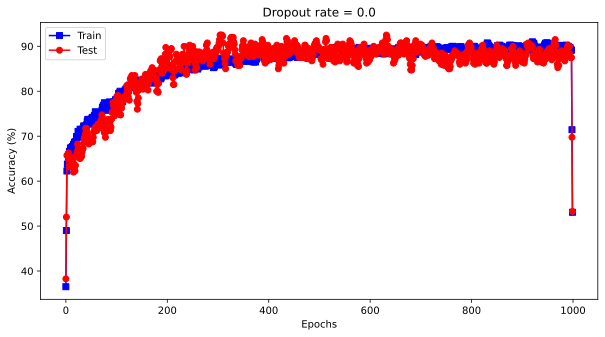

In [46]:
fig = plt.figure(figsize=(10,5))

plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train","Test"])
plt.title("Dropout rate = {}".format(dropoutRate))

plt.show()

### The empirical test of dropout

In [47]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for dI in range(len(dropoutRates)):
    
    ANNQC, lossFn, optimizer = createNet(dropoutRates[dI])
    trainAcc,testAcc = trainNet(ANNQC,lossFn,optimizer)
    
    results[dI,0] = np.mean(trainAcc[-100:])
    results[dI,1] = np.mean(testAcc[-100:])
    

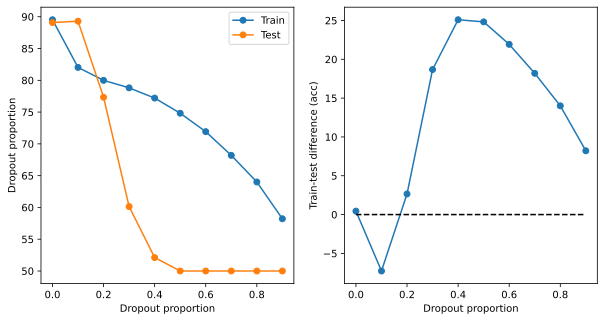

In [48]:
fig ,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel("Dropout proportion")
ax[0].set_ylabel("Dropout proportion")
ax[0].legend(["Train","Test"])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel("Dropout proportion")
ax[1].set_ylabel("Train-test difference (acc)")

plt.show()